# Design: Learning Object Construction Sequences
#### Erik Beerepoot, Eric Evje, Eagon Meng, Marcos Rios
#### 04/10/21

# Introduction

Fusion 360 is a computer aided design (CAD) software developed by Autodesk. This program and others like it are used by designers in many fields to design solid models from parametric sequences of more basic shapes and extrusions. When these models are saved in a software specific file format, the steps taken to construct the final shape are preserved. However, if a file has to change software packages, the original steps were lost due to saving as a file type that does not support, or if the solid model is made from a reconstruction of an arbitrary object 3D scanned into a computer, then these steps are lost or never existed in the first place. There is a desire to be able to take a solid model representation and automatically reconstruct the more basic steps taken to construct the model. Having the constituent steps makes editing the model easier by designers after this step, and could save time from reproducing the models by hand. 

Developers at Autodesk used the $Fusion 360 Gallery Dataset$, a collection of solid models and files that preserve the construction and 3D representation information of target models. They trained an imitation learning model on these steps, embedding the Q table in a message passing network (MPN) and developed a custom search algorithm to take in a target object, and the current state of reconstruction, allow an agent to step through developing the parametric steps needed to reconstruct the model exactly. They were successful, but there was room for improvement. 

We decided to augment their existing codebase to attempt and improve the functionaity and performance of their learning environment. We chose to develop and test two possible improvements, detailed in the notebook below. These improvements were:

- Modifying the network architecture to improve the MPN, both by increasing the depth and width of the deep neural network as well as connecting output layers more fully to attempt to boost performance. These efforts were relatively successfull and detailed in the `Modifying the network architecture` section. 
- Modifying the search function to search for additive steps to reach the target shape, as well as sequentially performing substrative steps from a bounding box shape to reach the target shape, then choose the reconstruction with higher intersection of union (IoU). This effort was unsuccessful but gave insight into future work that could expand on this. 

# Modifying the network architecture

### Overview

We made some changes to the model architecture to improve model performance. We made two modifications: First, we added the operation as an input to the MLPs predicting the start and end faces. The hypothesis was that depending on the type of operation being performed (say, a cut vs an additive operation), the prediction for start and end might be significantly different.

  Second, we increased both the width and depth of the graph convolution network (henceforth, GCN), the width of the fully connected layers, decreased the learning rate and increased the number of epochs. The original GCN contained only two layers: the input and output layers. As explained in the course material, the inner layers of CNNs will learn progressively higher level features (e.g, lines, shapes, etc). The intent behind the increased depth was to allow the network to learn better representations of the input graphs. The width of the hidden layers of the MLPs were increased as there were already several fully dense layers (i.e. adequate depth). The definition of the model is shown below.

```python
class DeepGCN(nn.Module):
    """ DeepGCN: A modified Graph Convolution network 
    with more layers """
    def __init__(self, nfeat, nhid, dropout):
        super(DeepGCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nhid)
        self.gc3 = GraphConvolution(nhid, nhid)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc3(x, adj))
        return x


class AugmentedNodePointer(nn.Module):
    """ AugmentedNodePointer: improved model that feeds the predicted 
    operation back into dense layers to predict start & end faces.
    """
    def __init__(self, nfeat, nhid, dropout=0.0, Use_GCN=True):
        super(NodePointer,self).__init__()
        self.Use_GCN=Use_GCN
        self.nhid=nhid

        # "embedding" layers
        if Use_GCN:
            self.fc00=nn.Linear(nfeat,nhid)
            self.fc01=nn.Linear(nhid,nhid)
            self.fc10=nn.Linear(nfeat,nhid)
            self.fc11=nn.Linear(nhid,nhid)
            self.fc20=nn.Linear(nfeat*2,nhid)
            self.fc21=nn.Linear(nhid,nhid)
            self.gcn0=DeepGCN(nfeat=nhid,nhid=nhid,dropout=dropout)
            self.gcn1=DeepGCN(nfeat=nhid,nhid=nhid,dropout=dropout)
            self.gcn2=DeepGCN(nfeat=nhid,nhid=nhid,dropout=dropout)
            self.fc02=nn.Linear(nhid,nhid)
            self.fc03=nn.Linear(nhid,nhid)
            self.fc12=nn.Linear(nhid,nhid)
            self.fc13=nn.Linear(nhid,nhid)
            self.fc22=nn.Linear(nhid,nhid)
            self.fc23=nn.Linear(nhid,nhid)
        else:
            self.fc00=nn.Linear(nfeat,nhid)
            self.fc01=nn.Linear(nhid,nhid)
            self.fc10=nn.Linear(nfeat,nhid)
            self.fc11=nn.Linear(nhid,nhid)
            self.fc20=nn.Linear(nfeat*2,nhid)
            self.fc21=nn.Linear(nhid,nhid)

        # "output" layers        
        self.fc_operation=nn.Linear(nhid,5)

        # feed in operation (augmented model)
        self.fc0=nn.Linear(nhid*2 + 5,nhid*2)
        self.fc1=nn.Linear(nhid*2,nhid*2)
        self.fc2=nn.Linear(nhid*2,nhid*2)
        self.fc3=nn.Linear(nhid*2,nhid*2)
        self.fc_start=nn.Linear(nhid*2,1)
        # feed in operation augmented model)
        self.fc4=nn.Linear(nhid  + 5,nhid)
        self.fc5=nn.Linear(nhid,nhid)
        self.fc6=nn.Linear(nhid,nhid)
        self.fc7=nn.Linear(nhid,nhid)
        self.fc_end=nn.Linear(nhid,1)
        
        for m in self.modules():
            if isinstance(m,nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.00)

    def forward(self, gpf, use_gpu):
        """ Perform a forward pass 
        gpf - formatted graph pair, defined as:
        [
            target graph (adjacency matrix)
            target features [{surface type, points, normals, trimming mask, edges}]
                - for each face, we have a dict of the above features
            current graph (adjacency matrix)
            current features [{surface type, points, normals, trimming mask, edges}]
                - for each face, we have a dict of the above features
            start face
            end face
            operation
            sequence name (e.g. 55928_1ccd0821_0001)
            sequence id 
        ]
        use_gpu - True if GPU should be used
        """
        
        # Using the above definition, we have
        # gpf[1] => features of all faces
        # ,gpf[1][gpf[4],:].repeat => features of the starting face repeated the match shape
        x2=torch.cat((gpf[1],gpf[1][gpf[4],:].repeat(gpf[1].size()[0],1)),dim=1)
        if self.Use_GCN:
            # Combine target graph with features
            x0=F.relu(self.fc01(F.relu(self.fc00(gpf[1]))))
            x0=self.gcn0(x0,gpf[0])
            x0=F.relu(self.fc03(F.relu(self.fc02(x0))))
            
            # Embed target graph with features of start face (repeated)
            x2=F.relu(self.fc21(F.relu(self.fc20(x2))))
            x2=self.gcn2(x2,gpf[0])
            x2=F.relu(self.fc23(F.relu(self.fc22(x2))))
            
            # If the current graph is empty, this is the first step in the sequence
            # so we set x1 to 0
            if gpf[2].size()[0]==0:
                if use_gpu:
                    x1=torch.zeros((1,self.nhid)).cuda()
                else:
                    x1=torch.zeros((1,self.nhid))
            # otherwise, embed current graph with features
            else:
                x1=F.relu(self.fc11(F.relu(self.fc10(gpf[3]))))
                x1=self.gcn1(x1,gpf[2])
                x1=F.relu(self.fc13(F.relu(self.fc12(x1))))
        else:
            # Same as above with graph nn
            x0=F.relu(self.fc01(F.relu(self.fc00(gpf[1]))))
            x2=F.relu(self.fc21(F.relu(self.fc20(x2))))
            if gpf[2].size()[0]==0:
                if use_gpu:
                    x1=torch.zeros((1,self.nhid)).cuda()
                else:
                    x1=torch.zeros((1,self.nhid))
            else:
                x1=F.relu(self.fc11(F.relu(self.fc10(gpf[3]))))
        
        # NOTE: At this point we have obtained embeddings (Figure 5, left box)
        # and now we proceed to pass them into a dense network
        
        # First, sum the current embedding (Figure 5, lower middle box)
        x1=torch.sum(x1,dim=0,keepdim=True).repeat(x0.size()[0],1)
        
        # Predict the operation (dense nn with 5 outputs)
        op=self.fc_operation(x1[0:1,:])
        
        # Use current & target embedding to predict start (single output)
        # and add the operation as an input 
        x4 = op.repeat(x0.size()[0], 1)      
        x=torch.cat((x0,x1,x4),dim=1)
        x=F.relu(self.fc0(x))
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x_start=self.fc_start(x)
        
        # Use target embedding with start face features to predict end (single output)
        x=torch.cat((x2, x4), dim=1)
        x2=F.relu(self.fc4(x))
        x2=F.relu(self.fc5(x2))
        x2=F.relu(self.fc6(x2))
        x2=F.relu(self.fc7(x2))
        x_end=self.fc_end(x2)
        return x_start, x_end, op
```

## Results and Analysis

Results from training the model are shown below. In the table, `original` refers to the original model, `augmented` refers to the model whereby the operation was fed into the MLP prediction start- and end faces, and `Augmented DeepGCN` refers to the deep-and-wide augmented model. Overall, we can see that that both changes yielded very slight improvements in accuracy. Note that the augmented DeepGCN model had the best training results by a wide margin. It appears that there is some overfitting, which could be mitigated by increasing dropout or increasing the amount of training data.

### Train

| Model  | Loss  | Start Accuracy  | End Accuracy  | Operation Accuracy | Overall Accuracy  |
|---|---|---|---|---|---|
| Original  | 0.46  | 92.59  |  96.24  | 96.52  | 88.17  |
| Augmented  | 0.43  | 92.24  | 97.17 | 96.67 | 88.54  |
| Augmented DeepGCN  |  0.18 |  95.27 | 98.94  | 99.25  | 94.18 |

### Test
| Model  | Loss  | Start Accuracy  | End Accuracy  | Operation Accuracy | Overall Accuracy  |
|---|---|---|---|---|---|
| Original  | 5.28  | 86.68  |  88.00  | 90.75  | 78.06  |
| Augmented  | 4.06  | 86.05  | 88.71 | 91.37 | 78.37  |
| Augmented DeepGCN  |  5.26 |  86.21 | 88.55  | 91.38  | 78.44 |


Refer to [this notebook](https://colab.research.google.com/drive/10-rlj6X5XiySVLyOLruMxzxP78QALxT2?usp=sharing) to see the details on how the original model was re-trained.

Refer to [this notebook](https://colab.research.google.com/drive/1TPnP0VzcImJmjIGrZ0jLlK9aQEhMzLXC?usp=sharing) to see the details on how the augmented models were trained.

# Search Algorithm Augmentation: Subtractive Modeling Process

The original `Reconstruction` search feature begins the search space with an empty graph, building up the body from `NewBodyFeatureOperation`, `JoinFeatureOperation`, `CutFeatureOperation`, or `IntersectFeatureOperation`. The search space is originally restricted to `NewBodyFeatureOperation` since the other operations are not possible on an empty graph. 

<p float="left"> 
  <img src=" 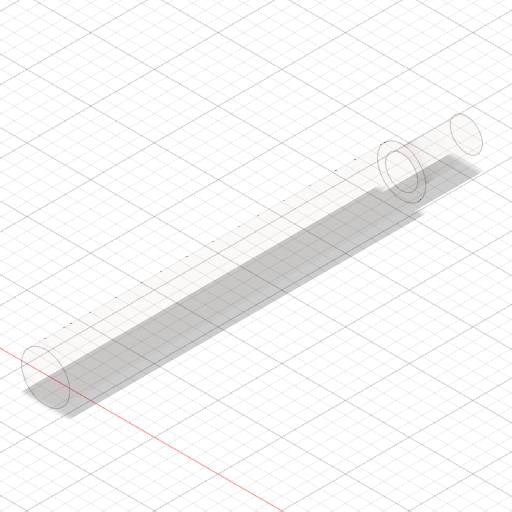" style="display:inline;margin:1px;height:300px" /> 
  <img src=" 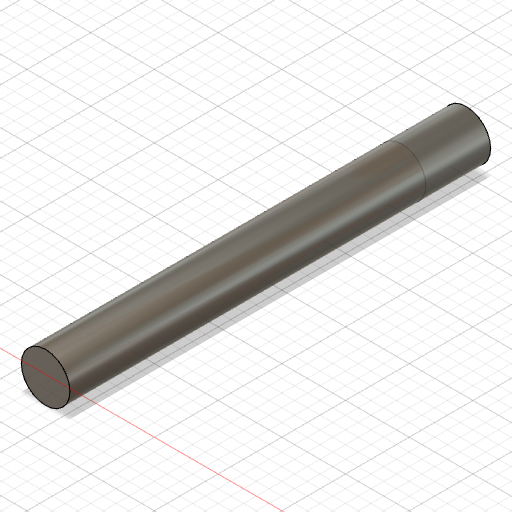" style="display:inline;margin:1px;height:300px" />  
  <img src=" 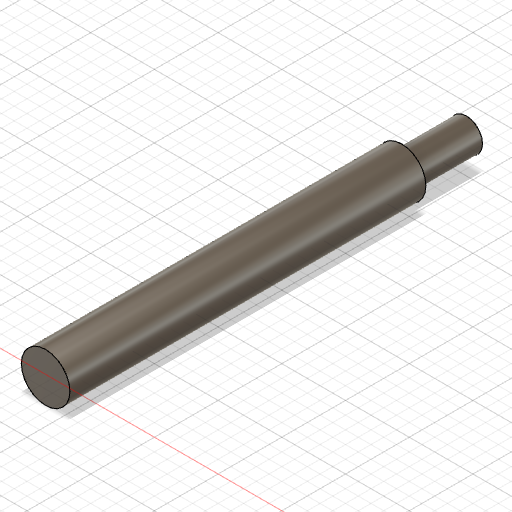" style="display:inline;margin:1px;height:300px" /> 
</p>

<center> Example face extrusion process for original best_search process </center>

## Simulating manufacturing processes in design

### Overview

There are 2 umbrellas of manufacturing for manufactured parts, additive manufacturing and subtractive manufacturing. Additive manufacturing, such as injection molding and 3D printing, *add* material to create a solid object. Opposite of this is machining, which starts with a block of materials and *subtracts* material to create the final design. Additive manufacturing is like working with clay, whereas subtractive manufacturing is like working with a granite block and chisel. 

Good design practices recommend designing your part in the way that it will be manufactured. If a part is to be manufactured via a subtractive manufacturing process, it is best practice to start your model as a block of material and cut away material. This allows the designer to visualize and optimize the design for the manufcaturing process and allows for easier editing of the design later on. 

The search feature implemented in the $Search$ class and its children start with a blank graph and *add* bodies to form the design. Though its possible for the agent to choose to extrude a bounding box then cut away to the target, it is not guaranteed, and typically not what happens. Further, due to the limitations imposed by the message passing network, namely the fact it returns 2 faces and an operation, as well the rules imposed on the agent (namely the faces must be parallel) there are several more complex shapes that it completely fails at making. Essentially, if there is a face with no parallel faces it canot be created. See examples below of a shape the agent fails to reconstruct. 

<p float="center"> 
  <img src=" 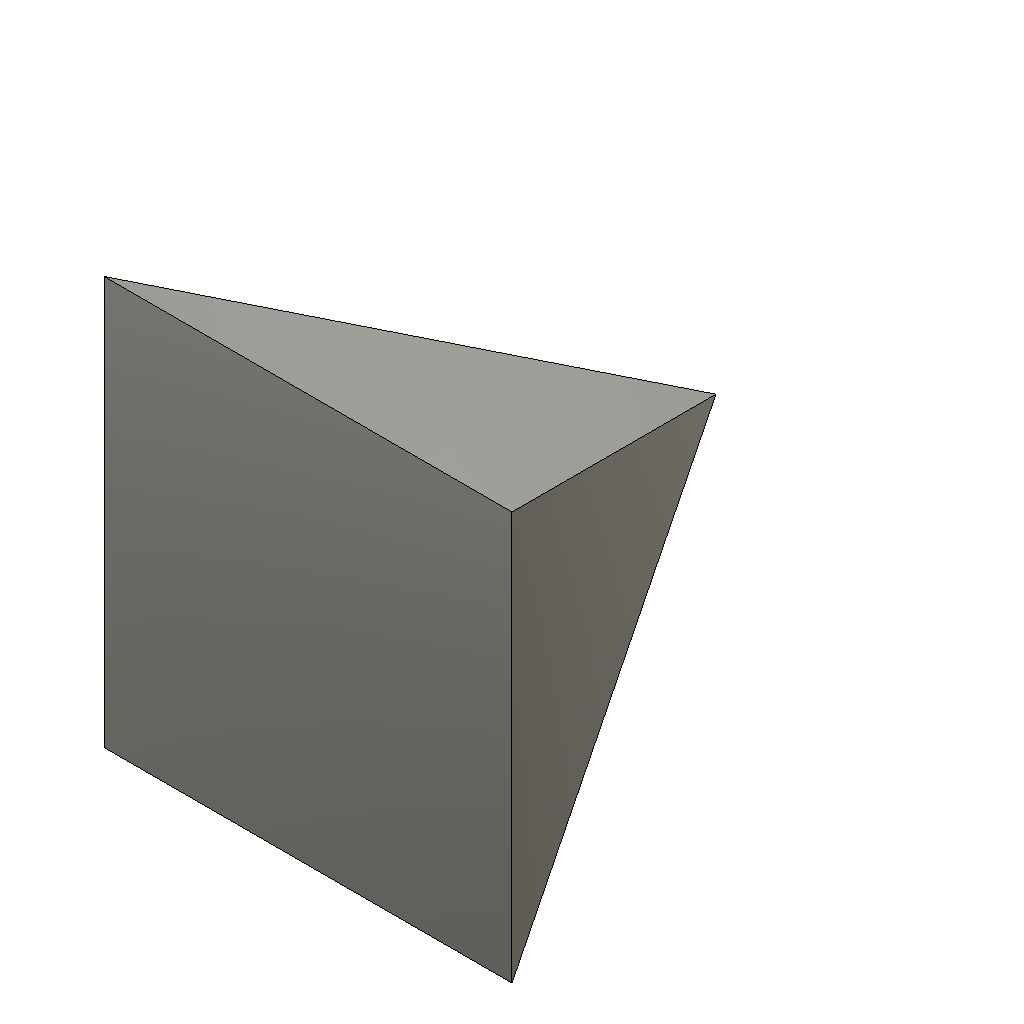" style="height:300px"/> 
</p>

<center> Pyramidal face with no parallel faces fails to be reconstructed </center>

Looking into the ground truth of the above model, it is apparent that the final model was formed from a bounding box, then two extrude cut operations were used to complete the shape. Since the final cuts go all the way through the model, there are no parallel faces for the agent to complete a face extrusion. 

<p float="center"> 
  <img src=" 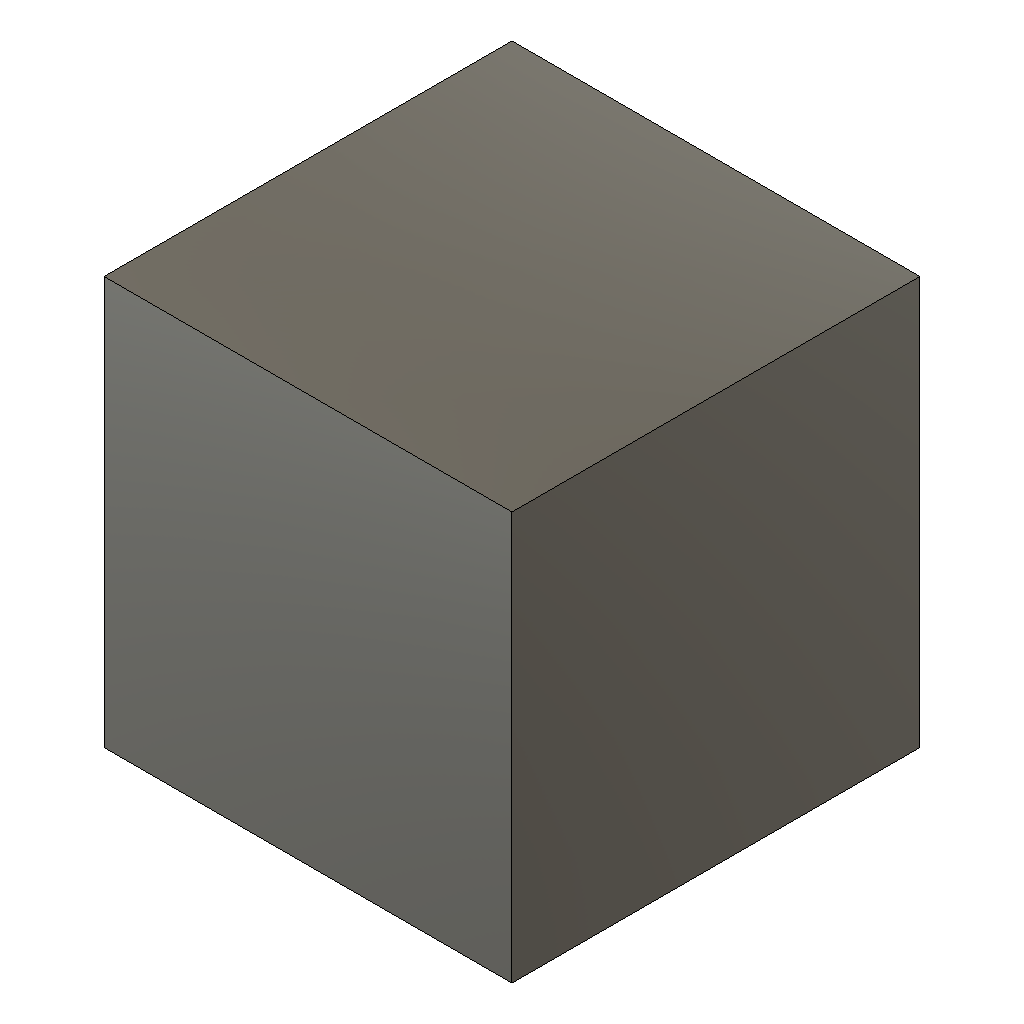" style="display:inline;margin:1px;height:300px" /> 
  <img src=" 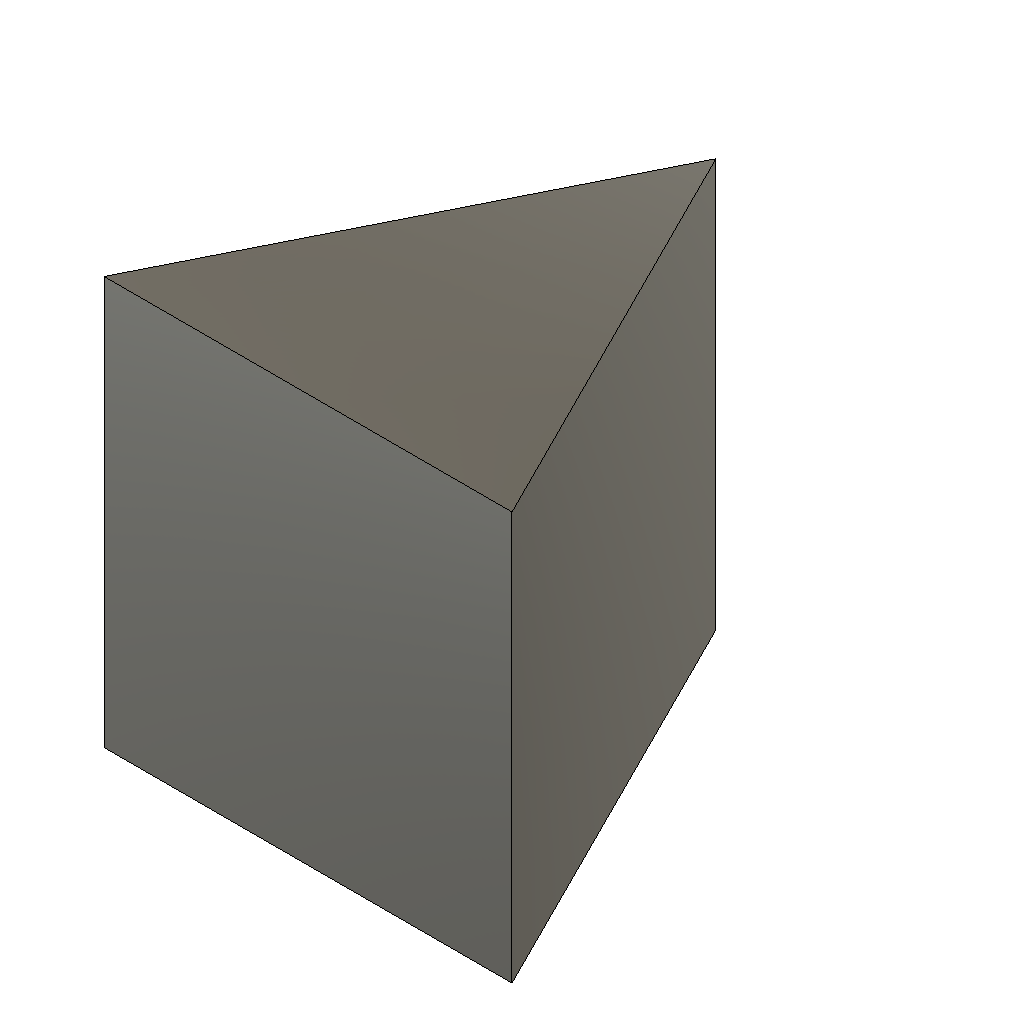" style="display:inline;margin:1px;height:300px" />  
  <img src=" 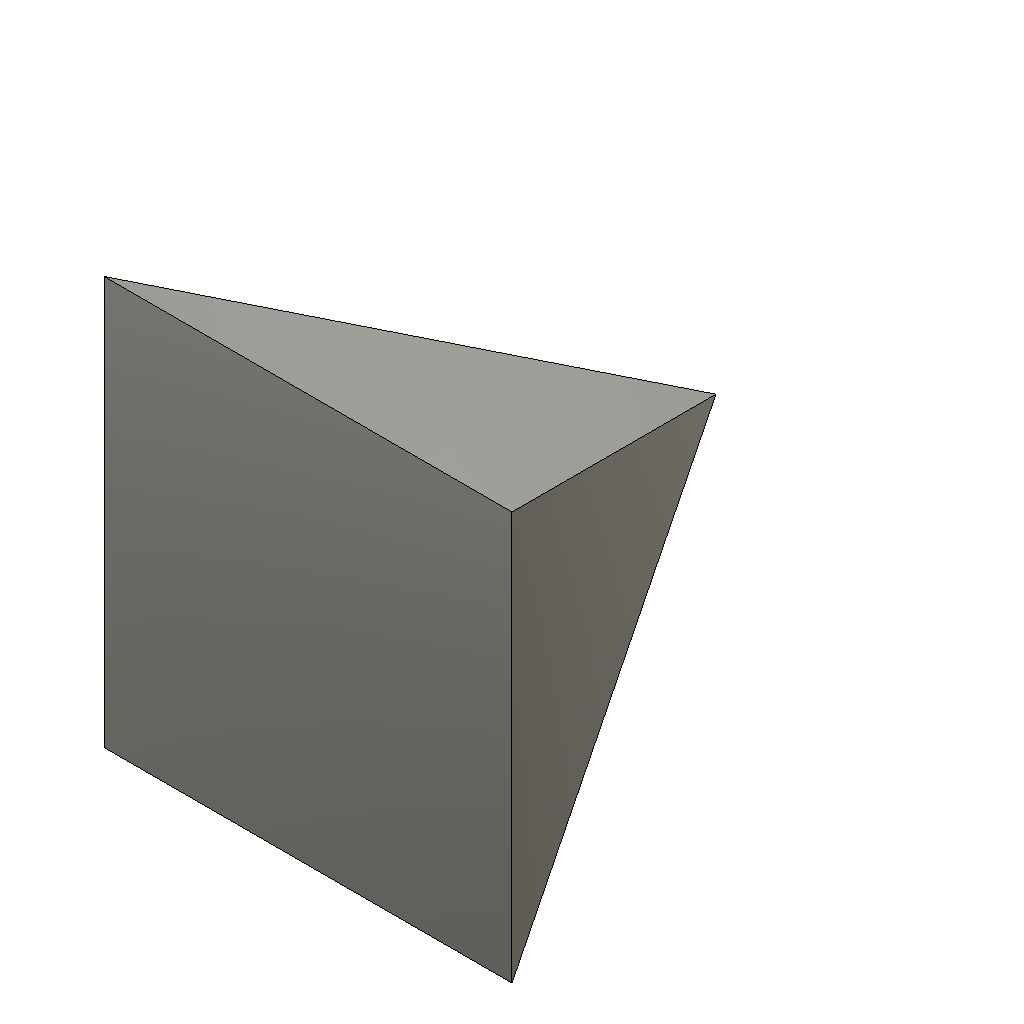" style="display:inline;margin:1px;height:300px" /> 
</p>

<center> Extrusion steps to recreate the solid object </center>

This particular model fails the search algorithm due to the parallel face limitation of face extrusions. If we were able to start with the bounding box and cut away to reveal the model, however, this could be reconstructed using the existing framework of the search algorithm.

### Implementation

The full implementation can be found in the group's [github repo](https://github.com/ericevje/cs109b-group44/tree/final). To implement this, we needed to modify the search algorithm to add a bounding box before each face extrusion operation. The code below was added to the `search_best` script used to search and update action probabilities based on the step or steps with best `IoU`. 

```python
    def search_bounding_box(self, agent, budget, max_point, min_point, score_function=None, screenshot=False):
        super().search_bounding_box(agent, budget, max_point, min_point, score_function, screenshot)
        # the length of rollout is the same as the number of planar faces as a maximum
        rollout_length = 0
        for node in self.target_graph["nodes"]:
            if node["surface_type"] == "PlaneSurfaceType":
                rollout_length += 1
        if rollout_length < 2:
            # There exist some designs with no planar faces that we can't handle
            # We need at least 2 faces
            raise Exception("Not enough valid planar faces in target")

        used_budget = 0
        max_score = 0
        max_scores = []

        fringe = PriorityQueue()
        fringe.put(PriorityAction(0, ()))

        # while there is item in the fridge and we still have budget
        while fringe.qsize() > 0 and used_budget < budget:
            # Revert environment to target and set current graph to bounding box

            ###################################################################
            # Instead of starting with a blank graph and adding, we start with
            # a bounding box and subtract from it
            self.env.revert_to_target()
            cur_graph = self.env.get_bounding_graph(min_point, max_point)
            ###################################################################
            
            priority_action = fringe.get()
            # nll is something like 10, prefix is something like (a1, a4, a10)
            nll = priority_action.nll
            prefix = priority_action.prefix
            new_graph, cur_iou = self.env.extrudes(list(prefix), revert=False)

            if len(prefix) > 0:
                used_budget += 1
                take_screenshot = screenshot
                if cur_iou is not None:
                    max_score = max(max_score, cur_iou)
                else:
                    # We only want to take screenshots when something changes
                    take_screenshot = False
                if new_graph is not None:
                    cur_graph = new_graph

                log_data = {
                    # "rollout_attempt": rollout_attempt,
                    # "rollout_step": i,
                    # "rollout_length": rollout_length,
                    "used_budget": used_budget,
                    "budget": budget,
                    "current_iou": cur_iou,
                    "max_iou": max_score,
                    "prefix": list(prefix)
                }
                self.log.log(log_data, take_screenshot)
                max_scores.append(max_score)
                # Stop early if we find a solution
                if math.isclose(max_score, 1, abs_tol=0.00001):
                    return max_scores
                # Stop if the rollout hits the budget
                if used_budget >= budget:
                    break
            # If there was an invalid operation
            # continue without adding it to the search space
            if (new_graph is None or cur_iou is None) and len(prefix) > 0:
                continue

            # extend the current prefix by 1 step forward
            actions, action_probabilities = agent.get_actions_probabilities(cur_graph, self.target_graph)
            # Filter for clearly bad actions
            action_probabilities = self.filter_bad_actions_bounded(cur_graph, actions, action_probabilities)
            # Convert probability to logpr so they can be added rather than multiplied for numerical stability
            action_logprs = np.log(action_probabilities)
            # add to the candidates back to fringe
            for (a, a_logpr) in zip(actions, action_logprs):
                child_prefix = prefix + (a,)
                child_nll = nll - a_logpr
                # do not add a prefix that's longer than rollout length
                if len(child_prefix) < rollout_length:
                    fringe.put(PriorityAction(child_nll, child_prefix))

            print(f"[{used_budget}/{budget}] Score: {max_score}")
        return max_scores
```

We call the Fusion 360 environment and the custom function, `get_bounding_graph` which does the following:

```python
    def get_bounding_graph(self, min_point, max_point):
        """Wrapper to extrude a bounding rectangle around a solid model"""
        _min_point = min_point
        _max_point = max_point

        start_face, end_face = self.boundary_points(_min_point, _max_point)
        distance = _max_point[0] - _min_point[0]

        # Create a new sketch vias the server client
        r = self.client.add_sketch("XY")
        response_json = r.json()
        sketch_name = response_json["data"]["sketch_name"]

        # Add points to new sketch
        for i, point in enumerate(start_face):
            r = self.client.add_point(sketch_name, 
                {"x": point[0], "y": point[1], "z":point[2]})
            response_json = r.json()

        # Close profile of points to make a face to extrude
        r = self.client.close_profile(sketch_name)
        response_json = r.json()
        profile_id = (list(response_json['data']['profiles'].keys())[0])

        # Extrude by distance between start and end face
        r = self.client.add_extrude(sketch_name, profile_id, -1 * distance, "NewBodyFeatureOperation")

        # Convert extrusion to graph and return graph format
        r = self.client.graph(file='', dir='', format='PerFace')
        response_json = r.json()
        return response_json['data']['graph']
```
```python
def boundary_points(self, min_point, max_point):
        """Return points needed to make a boundary extrude encompassing model"""
        start_face = []
        end_face = []
        start_face.append(min_point)
        start_face.append((min_point[0], min_point[1], max_point[2]))
        start_face.append((min_point[0], max_point[1], max_point[2]))
        start_face.append((min_point[0], max_point[1], min_point[2]))

        end_face.append((max_point[0], min_point[1], min_point[2]))
        end_face.append((max_point[0], min_point[1], max_point[2]))
        end_face.append((max_point[0], max_point[1], max_point[2]))
        end_face.append((max_point[0], max_point[1], min_point[2]))

        return start_face, end_face
```

This creates a bounding box around the target object. Then, through the function `filter_bad_actions_bounded` we force the probabilities to near zero of any operation that is not a `CutFeatureOperation` operation as shown in the code snippet below:

<p float="center"> 
  <img src=" 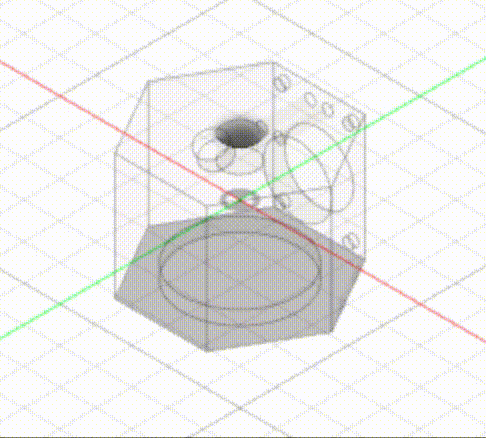" style="height:200px"/> 
</p>

<center> GIF showing the bounding box extrusion step </center>

```python
def filter_bad_actions_bounded(self, current_graph, actions, action_probabilities):
        """Filter out some actions we clearly don't want to take"""
        assert self.target_graph is not None
        epsilon = 0.00000000001
        # Adjust the probabilities of bad actions
        for index, action in enumerate(actions):
            if action["operation"] == "NewComponentFeatureOperation":
                action_probabilities[index] = epsilon
            if action["operation"] != "CutFeatureOperation":
                action_probabilities[index] = epsilon
            if action_probabilities[index] < epsilon:
                action_probabilities[index] = epsilon

        action_probabilities = action_probabilities / sum(action_probabilities)
        return action_probabilities
```

### Results

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import sys
import os
from IPython.core.display import display, HTML, Image

In [105]:
control_log = "../tools/search/log/"
bounded_log = "../tools/search/log_bounded/"

In [106]:
control_directories = os.listdir(path=control_log)
bounded_directories = os.listdir(path=bounded_log)

In [107]:
dict_df = {'uuid': [],
             'used_budget': [],
             'max_iou': [],
             'exact': [],
             'bounded': []}

In [108]:
bounded = False
for directory in control_directories:
    # Return all files within directory
    try:
        files = os.listdir(os.path.join(control_log, directory))
        for file in files:
            if file.endswith('.json'):
                with open(os.path.join(control_log, directory, file), 'r') as f:
                    f = json.load(f)
                    dict_df['uuid'].append(directory)
                    dict_df['used_budget'].append(f[-1]['used_budget'])
                    dict_df['max_iou'].append(f[-1]['max_iou'])
                    dict_df['exact'].append(True if f[-1]['max_iou'] > 0.99999999 else False)
                    dict_df['bounded'].append(bounded)
    except NotADirectoryError:
        print("{} is not a directory".format(directory))
        
bounded = True
for directory in bounded_directories:
    # Return all files within directory
    try:
        files = os.listdir(os.path.join(bounded_log, directory))
        for file in files:
            if file.endswith('.json'):
                with open(os.path.join(bounded_log, directory, file), 'r') as f:
                    f = json.load(f)
                    dict_df['uuid'].append(directory)
                    dict_df['used_budget'].append(f[-1]['used_budget'])
                    dict_df['max_iou'].append(f[-1]['max_iou'])
                    dict_df['exact'].append(True if f[-1]['max_iou'] > 0.99999999 else False)
                    dict_df['bounded'].append(bounded)
    except NotADirectoryError:
        print("{} is not a directory".format(directory))

.DS_Store is not a directory
search_results.json is not a directory
.DS_Store is not a directory
search_results.json is not a directory


In [109]:
df = pd.DataFrame(dict_df)

In [110]:
df.groupby(by='bounded')['max_iou'].describe()

count      mean       std  min       25%       50%       75%  \
bounded                                                                 
False     11.0  0.888437  0.298132  0.0  0.944104  1.000000  1.000000   
True      11.0  0.294129  0.373506  0.0  0.000000  0.056893  0.639158   

              max  
bounded            
False    1.000000  
True     0.943616

In [111]:
df.groupby(by='bounded')['used_budget'].describe()

count  mean      std   min   25%   50%   75%   max
bounded                                                    
False     11.0   9.0  8.97775   1.0   1.0   5.0  20.0  20.0
True      11.0  20.0  0.00000  20.0  20.0  20.0  20.0  20.0

### Analysis

We tested the new search algorithm against the `search` function in `search_best` on a subset of the test set. Testing on the entire set proved to be a time intensive task, and early results from the subset were not promising. 

The implementation did not work as expected. Unfortunately, the agent is not able to use the faces of the bounding box to create extrude cuts, so the best we were able to do was an exact negative of the object. The tables above show the maximum `IoU` achieved for the `bounded=True` group was 0.943, so no exact reconstructions were created. Further the mean `IoU` was only $0.29$ as compared to $0.88$ for the original implementation.

The figures below show the issue. The bounding box is created, but often the only valid moves left are to cut away the target object.

<p float="left"> 
  <img src=" 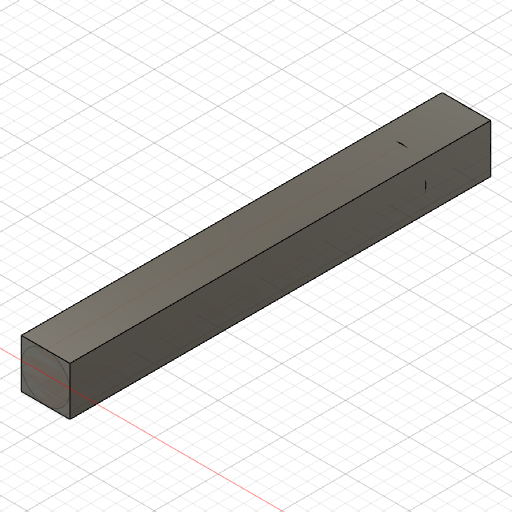" style="display:inline;margin:1px;height:300px" /> 
  <img src=" 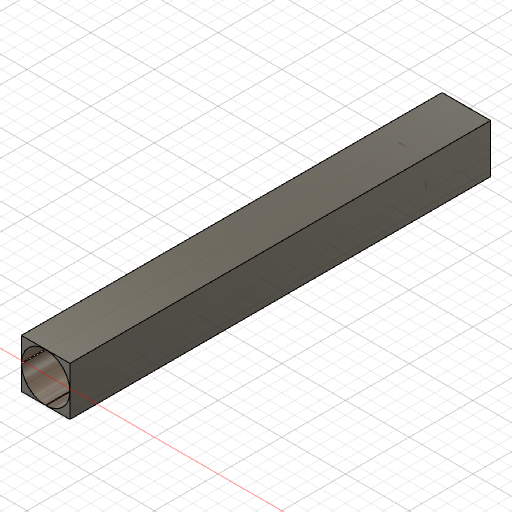" style="display:inline;margin:1px;height:300px" />  
  <img src=" 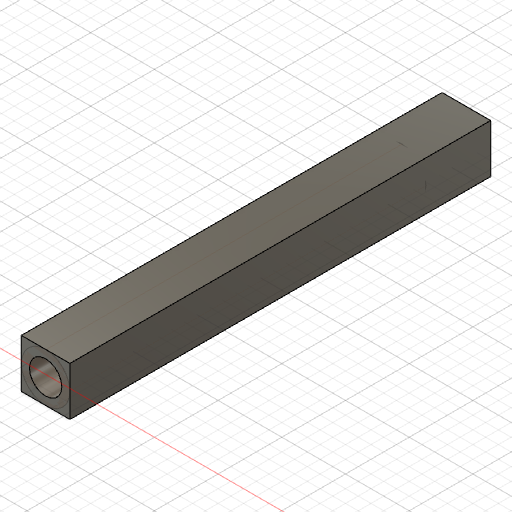" style="display:inline;margin:1px;height:300px" /> 
</p>

<center> Search with bounded object and operation space reduced to cuts only </center>

We do believe though that this implementation could work with added layers of complexity that were not available through the original `train` and `search` functionality provided. To replicate this, the process could be something such as the following psuedocode below:

1. `set_target(target)`
2. `create_bounding_box(target)`
3. `inverse_target = intersect_cut_operation() #returns a body that is the volume of the bounding box specifically not within the target`
4. `set_target(inverse_target)`
5. `reconstruct(target) #Until IoU=0`
6. `inverse the steps found in reconstruct #joins become cuts and vice versa`
7. `Insert bounding box as first step`

If this was run in parallel or sequentially with the additive search, we may be able to improve the exact reconstruction percent of the search features.

### Projection Reconstruction

The primary issue with the current approach is the reliance on face extrude from faces defined already on the target - as we have explored above, this constrains not only the possible search space, but also prevents certain geometries from being computed at all.

We propose an extremely simple but novel approach in the context of face-extrude, building off our earlier work on bounding box trimming. Instead of limiting the distribution of actions to parallel faces in the target geometry, we extend that space to the 2D projections along all three coordinate planes: X-Y, Y-Z, and X-Z. The projections of the target geometry form intersections with the desired target, and these operations equivalent to boolean AND are always valid as a first pass for a target reconstruction.

We implemented a simple algorithm that works directly as a Fusion 360 script that can be called from the UI interface, or run as a plugin. This algorithm computes the necessary projections for each face, and creates the B-Rep sketches necessary to extrude each projection. The script is as follows:

```python

import adsk.core, adsk.fusion, adsk.cam, traceback

def run(context):
    ui = None
    try:
        app = adsk.core.Application.get()
        ui = app.userInterface
        product = app.activeProduct
        design = adsk.fusion.Design.cast(product)
        rootComp = design.rootComponent
        bodies = rootComp.bRepBodies
        body = bodies.item(0)
        sketches = rootComp.sketches
        xy_sketch = sketches.add(rootComp.xYConstructionPlane)
        yz_sketch = sketches.add(rootComp.yZConstructionPlane)
        xz_sketch = sketches.add(rootComp.xZConstructionPlane)

        all_aspects = [xy_sketch, yz_sketch, xz_sketch]

        for face in body.faces:
            for aspect in all_aspects:
                aspect.project(face)
    except:
        if ui:
            ui.messageBox('Failed:\n{}'.format(traceback.format_exc()))
```

The projection script is more generalizable in that it works directly on Fusion 360's python API, and can be computed as part of a preprocessing step. In particular, it enables the existing algorithm to take advantage of an extended set of possible sketches to extrude from, with the intersection operation as the primary action. Here is an example of the script at work:

<p float="center"> 
  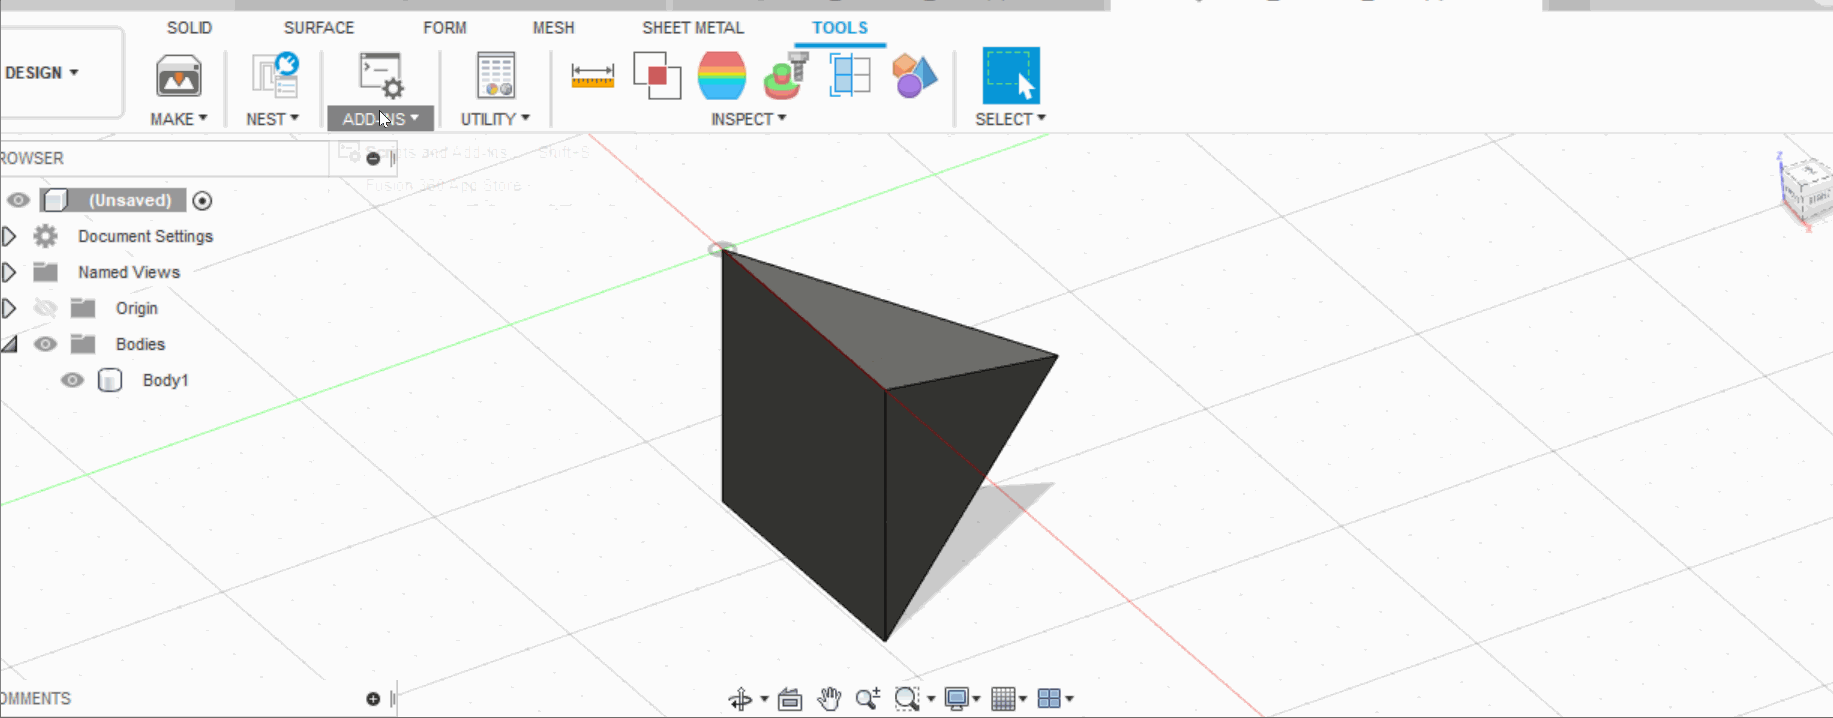 
</p>

<center> Projection plugin at work on pyramid example </center>


The above presents a solution to the same example of the pyramid where there do not exist any parallel faces in the target geometry. This not only limits the expressivity of the current approach, but the model in fact does not run at all, since no face is available that satisfies the parallel criteria. By extending the projection onto the bounding box, we create faces that enable the search algorithm to complete the modeling.

To show that these faces extrude perfectly to the final target geometry, consider the following intersection projections along each axis:
<p float="center"> 
  <img src=" 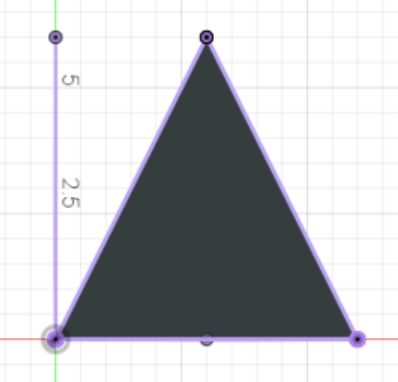" style="height:200px" /> 
</p>

<center> X-Y projection of a geometry maps directly onto intersection operation</center>

<p float="center"> 
  <img src=" 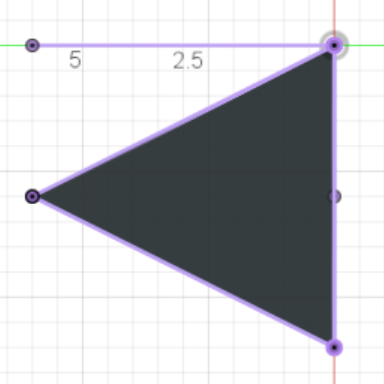" style="height:200px" /> 
</p>

<center> Z-Y projection of a geometry completes pyramid</center>


### Future Directions

The work on simulating manufacturing processes, and the construction of a projection tool, is the first step in expanding the capabilities of generalized model able to fully reconstruct operations for most geometries. One key hindrance in further progress is the fact that the training is done against a gold-standard sequence (in this case pretrained as well), which leaves no room for degenerate solutions. In particular, in attempting to implement the training with the widened action space including the projections described above, the model proved to be inflexible and would not assign any significant probability to the novel approaches of paring down the bounding box.

These explorations can be motivation to reconsider the structure of the training data - perhaps there is room for data augmentation and permutation of degenerate solutions, as given any target geometry there are solutions that overlap and can permutate local action sequences freely. 

In addition, as a technical side note, training and model handling was in general quite slow due to needing to go through the hoops of communicating through Fusion 360's API and the additional server-wrapper. Upon inspection, a large portion of the source code seemed to not only deal with, but also preemptively expect constant server crashes and inject automatic restart capabilities. This may have motivated the loss function operating entirely within the deep Q-network, which may prove inflexible in establishing new loss paradigms such as entropy of shape complexity, etc.

# Conclusion

We attempted to improve the performance of the Fusion 360 Reconstruction Learning Network by improving the MPN with which Q scores for the agent to retrieve were stored, as well as the search algorithm used by the agent to attempt several passes through the search space to find a solution. The augmentation of the MPN resulted in modest improvements to train and test loss and accuracies, and with more general tuning can potentially result in decent performance gains.

The approach of simulating the manufacturing process by paring down from a block of material, or from a bounding box, yielded a number of interesting observations about the structure of the model, it's loss function and optimization strategy, and the viability of such an approach. While the implementation of the direct search suggestions did not work in the context of the current model, our explorations led us to proposing a projection paradigm that augments the target geometry with the 2D projections along each plane on the bounding box. This simple preprocessing step in generating additional sketches enables the possibility of the model to solve a class of problems that it could not before, as demonstrated with the pyramid geometry example above.

In summary, we 

1. **expanded upon the original model's architecture**, yielding modest gains
2. investigated a **novel bounding box approach** to simulate manufacturing processes
3. **enabled the algorithm to solve a class of problems** it previously could not operate on

and hope that our results and research prove helpful.